<a href="https://colab.research.google.com/github/julialukomska70/JuliaLukomska-DataScience-GenAI-submission/blob/main/4_01_Decision_Trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://drive.google.com/uc?export=view&id=1xqQczl0FG-qtNA2_WQYuWePW9oU8irqJ)

# 4.01 Decision Trees

Following up on our logistic regression example, we will also run an equivalent using _decision trees_.

We'll begin using the inbuilt dataset from scikit-learn we used previously. The dataset is for predicting the presence of breast cancer or not. You can get more details here: [https://scikit-learn.org/1.5/datasets/toy_dataset.html](https://scikit-learn.org/1.5/datasets/toy_dataset.html). The code is the same as in the previous example.

In [ ]:
import pandas as pd
import numpy as np

from sklearn.datasets import load_breast_cancer

# import the data
data = load_breast_cancer()

# create a DataFrame of features
x_values = pd.DataFrame(data.data, columns=data.feature_names)

from sklearn.preprocessing import MinMaxScaler

# create a MinMaxScaler object
scaler = MinMaxScaler()

# fit and transform the data
normal_data = scaler.fit_transform(x_values)

# recreate x_values using the scaled data and original feature names
x_values = pd.DataFrame(normal_data, columns=data.feature_names)

# create y value
y_value = pd.DataFrame(data.target, columns=['class'])
y_value = np.ravel(y_value)

## Train-Test split
As before, our next step will be to split the data:

In [ ]:
# split data into training and test
from sklearn.model_selection  import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x_values, y_value, test_size = 0.2, random_state=1984, stratify=y_value)

# print the shapes to check everything is OK
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(455, 30)
(114, 30)
(455,)
(114,)


Our code is basically the same as before except with an extra parameter ("stratify=y_value"). This part means we make sure there is a propotionate number of each class in our training data. We want to avoid having minimal examples of one of the classes to learn from (as the split is otherwise fully random).

We can confirm this has worked by looking at the size of our different datasets:


*   `X_train` (the $x$ values we use for training) is 455 rows and 30 columns;
*   `X_test` (the $x$ values we use for testing) is 114 rows and 30 columns;
*   `Y_train` (the $Y$ values we use for training) is 455 rows and a single column;
*   `Y_test` (the $Y$ values we use for testing) is 114 rows and a single columns. All seems to be correct!

## Decision Trees
We'll begin with a standard decision tree model WITHOUT adjusting for any hyperparameters. We first need to specify the model:

In [ ]:
from sklearn.tree import DecisionTreeClassifier as DTC

# create the model
DTC_algo = DTC()
DTC_algo

DecisionTreeClassifier()

As before, this is the unfitted/untrained algorithm. Let's make a model:

In [ ]:
DTC_model = DTC_algo.fit(X_train, Y_train)
DTC_model

DecisionTreeClassifier()

But how does it perform? I'll give you a metric for free, but you will then have to create some more:

In [ ]:
from sklearn.metrics import accuracy_score

# predict the test data
predict = DTC_model.predict(X_test)

# seperate the first five predictions and the first five real values in Y_test
for i in range(5):
  print(f'Predicted: {round(predict[i],2)}')
  print(f'Real: {Y_test[i]}')
  print("\n")

print("\n")

print(f'Accuracy: {round(accuracy_score(Y_test, predict),2)}')

Predicted: 0
Real: 0


Predicted: 0
Real: 0


Predicted: 0
Real: 0


Predicted: 0
Real: 0


Predicted: 1
Real: 1




Accuracy: 0.95


We have strong performance ... 90% accuracy. However, not as good as Logistic Regression. Let's look at the confusion matrix:

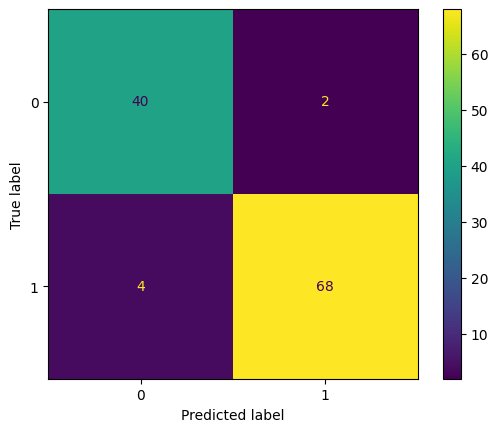

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay as CM

# create a confusion matrix
CM.from_predictions(Y_test, predict)

We can also extract the precision, recall and F1 score:

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Calculate precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(Y_test, predict, average='micro')

print(f"Micro-averaged Precision: {round(precision, 2)}")
print(f"Micro-averaged Recall: {round(recall, 2)}")
print(f"Micro-averaged F1-score: {round(f1_score, 2)}")
print("\n")

precision, recall, f1_score, _ = precision_recall_fscore_support(Y_test, predict, average='macro')

print(f"Macro-averaged Precision: {round(precision, 2)}")
print(f"Macro-averaged Recall: {round(recall, 2)}")
print(f"Macro-averaged F1-score: {round(f1_score, 2)}")

Micro-averaged Precision: 0.95
Micro-averaged Recall: 0.95
Micro-averaged F1-score: 0.95


Macro-averaged Precision: 0.94
Macro-averaged Recall: 0.95
Macro-averaged F1-score: 0.94


We can also see our tree:

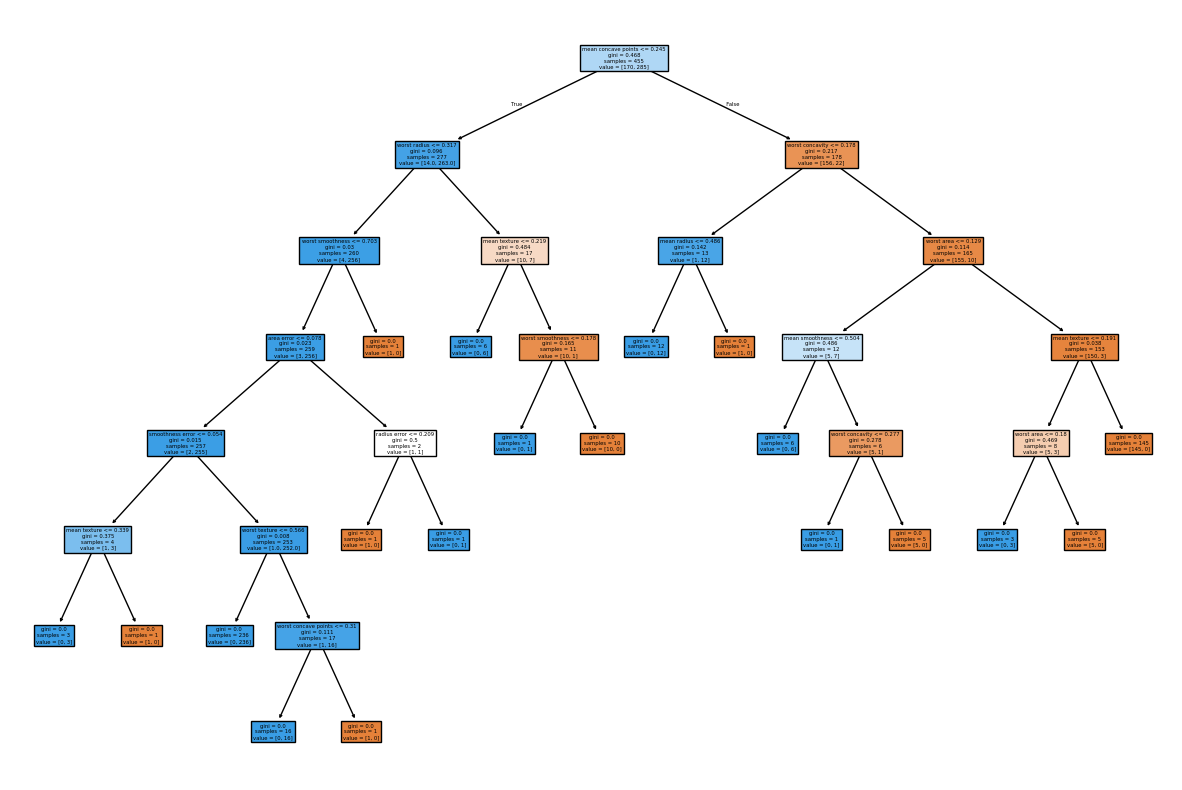

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
plot_tree(DTC_model, filled=True, feature_names=X_train.columns)
plt.show()

We can see it has built a fairly large tree ... maybe it has overfit? Perhaps regularisation will help ...

We can search our hyperparameters and see what would be best:

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# this is the list of parameters we will tune. Some are fixed values some are distributions
tuned_parameters = {
    'criterion': ['gini', 'entropy'],
    'max_depth': randint(3, 9),  # Draw from a uniform distribution between 3 and 15
    'min_samples_split': randint(3, 9),  # Draw from a uniform distribution between 2 and 10
    'max_features': ['sqrt', 'log2', None]
}

# we will tune against f1_macro (to find the best choice)
score = 'f1_macro' # arbitrary choice

print(f"Tuning hyperparameters for {score}")
print("\n")

# do the search using 5 folds/chunks
clf = RandomizedSearchCV(DTC(), tuned_parameters, cv=5, random_state=1984,
                         scoring= score, n_iter=20, refit=True)

# pass the data to fit/train
clf.fit(X_train, Y_train)

print("Best parameters set found on the training set:")
print(clf.best_params_)


Tuning hyperparameters for f1_macro


Best parameters set found on the training set:
{'criterion': 'gini', 'max_depth': 7, 'max_features': None, 'min_samples_split': 7}


Now we can train the model again, but using these hyperparameters:

In [ ]:
DTC_algo = DTC(**clf.best_params_) # get the best parameters from grid search
DTC_model = DTC_algo.fit(X_train, Y_train)

And now we can predict again:

In [ ]:
# predict the test data
predict = DTC_model.predict(X_test)

# seperate the first five predictions and the first five real values in Y_test
for i in range(5):
  print(f'Predicted: {round(predict[i],2)}')
  print(f'Real: {Y_test[i]}')
  print("\n")

print("\n")

print(f'Accuracy: {round(accuracy_score(Y_test, predict),2)}')

Predicted: 0
Real: 0


Predicted: 0
Real: 0


Predicted: 0
Real: 0


Predicted: 0
Real: 0


Predicted: 1
Real: 1




Accuracy: 0.93


Accuracy is better. However, we tuned for F1 macro ... maybe this will be better too:

Micro-averaged Precision: 0.93
Micro-averaged Recall: 0.93
Micro-averaged F1-score: 0.93


Macro-averaged Precision: 0.92
Macro-averaged Recall: 0.94
Macro-averaged F1-score: 0.93




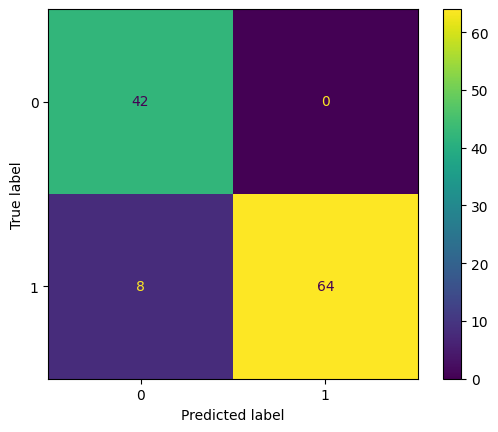

In [ ]:
# create a confusion matrix
CM.from_predictions(Y_test, predict)

# Calculate precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(Y_test, predict, average='micro')

print(f"Micro-averaged Precision: {round(precision, 2)}")
print(f"Micro-averaged Recall: {round(recall, 2)}")
print(f"Micro-averaged F1-score: {round(f1_score, 2)}")
print("\n")

precision, recall, f1_score, _ = precision_recall_fscore_support(Y_test, predict, average='macro')

print(f"Macro-averaged Precision: {round(precision, 2)}")
print(f"Macro-averaged Recall: {round(recall, 2)}")
print(f"Macro-averaged F1-score: {round(f1_score, 2)}")
print("\n")

F1 score is 3 points higher! Let's also check the tree:

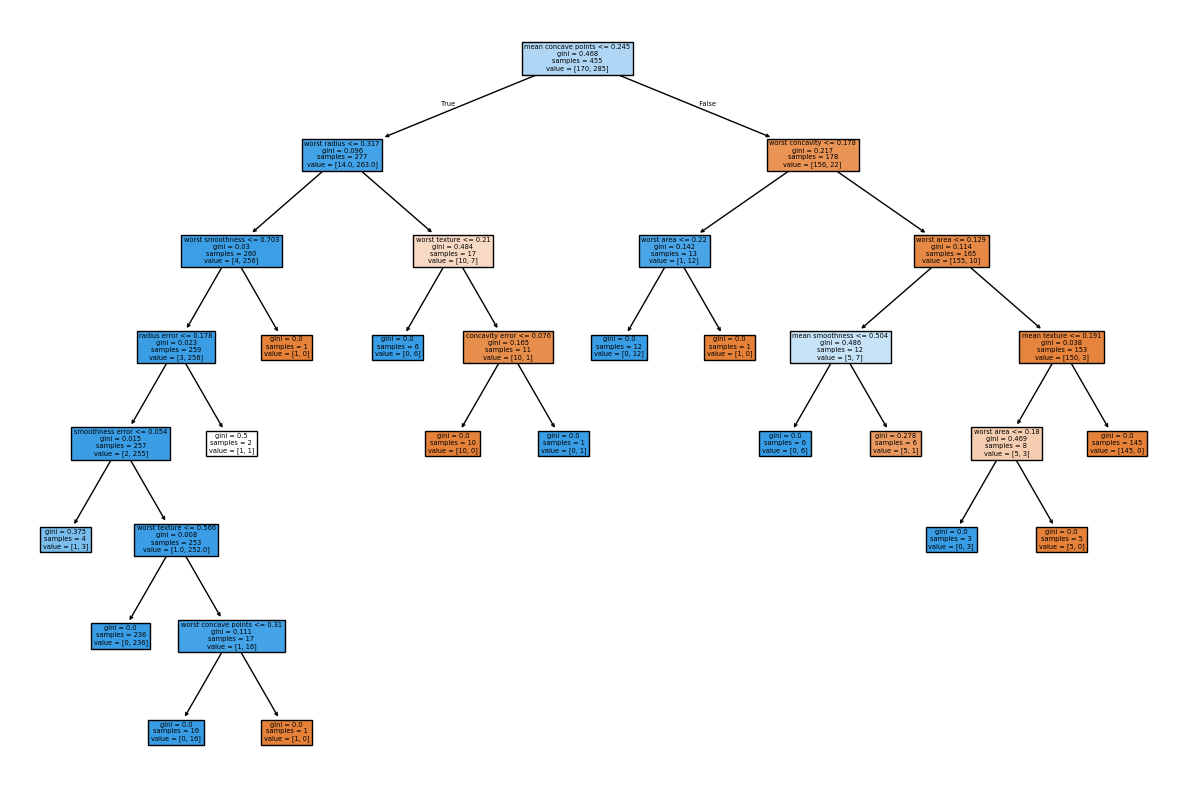

In [ ]:
plt.figure(figsize=(15, 10))
plot_tree(DTC_model, filled=True, feature_names=X_train.columns)
plt.show()

A much smaller tree so likely to be less prone to overfitting!

### TASK
Given that this is a medical domain, possibly a better metric to optimise against would be _recall_. Reoptimise the model according to _macro recall_ and evaluate the results.





In [ ]:
# Your code here

# Task
Reoptimize the Decision Tree model by running `RandomizedSearchCV` to find the best hyperparameters, optimizing for 'recall_macro'. Then, train a new Decision Tree Classifier with these optimal parameters, predict on the test data (`X_test`), and evaluate its performance by calculating and printing the accuracy, displaying the confusion matrix, and calculating and printing micro and macro-averaged precision, recall, and F1-score. Finally, visualize the newly trained Decision Tree and summarize the results, comparing them to the previous model.

## Reoptimize Model with Macro Recall

### Subtask:
Re-run `RandomizedSearchCV` to find the best hyperparameters for the Decision Tree Classifier, but this time optimize for 'recall_macro' instead of 'f1_macro'.


**Reasoning**:
The subtask requires re-running RandomizedSearchCV to optimize for 'recall_macro'. This code block will update the scoring parameter and then perform the hyperparameter search and print the best parameters.



In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# This is the list of parameters we will tune. Some are fixed values some are distributions
tuned_parameters = {
    'criterion': ['gini', 'entropy'],
    'max_depth': randint(3, 9),  # Draw from a uniform distribution between 3 and 15
    'min_samples_split': randint(3, 9),  # Draw from a uniform distribution between 2 and 10
    'max_features': ['sqrt', 'log2', None]
}

# We will tune against recall_macro
score = 'recall_macro'

print(f"Tuning hyperparameters for {score}")
print("\n")

# Do the search using 5 folds/chunks
clf_recall = RandomizedSearchCV(DTC(), tuned_parameters, cv=5, random_state=1984,
                         scoring= score, n_iter=20, refit=True)

# Pass the data to fit/train
clf_recall.fit(X_train, Y_train)

print("Best parameters set found on the training set (optimizing for recall_macro):")
print(clf_recall.best_params_)

Tuning hyperparameters for recall_macro


Best parameters set found on the training set (optimizing for recall_macro):
{'criterion': 'gini', 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 8}


**Reasoning**:
The next step is to train a new Decision Tree Classifier using the best hyperparameters found by `RandomizedSearchCV` when optimizing for 'recall_macro'.



In [ ]:
DTC_algo_recall = DTC(**clf_recall.best_params_) # get the best parameters from grid search optimized for recall_macro
DTC_model_recall = DTC_algo_recall.fit(X_train, Y_train)
print("Decision Tree Classifier trained with best parameters optimized for recall_macro.")

Decision Tree Classifier trained with best parameters optimized for recall_macro.


**Reasoning**:
Now that the model has been trained with the optimized hyperparameters, the next step is to use this model to make predictions on the test dataset (`X_test`) to evaluate its performance.



In [ ]:
predict_recall = DTC_model_recall.predict(X_test)
print("Predictions on the test data using the recall-optimized model have been made.")

Predictions on the test data using the recall-optimized model have been made.


**Reasoning**:
The next step is to calculate and display the accuracy of the recall-optimized model on the test data, as part of the overall performance evaluation.



In [ ]:
from sklearn.metrics import accuracy_score

accuracy_recall = accuracy_score(Y_test, predict_recall)
print(f'Accuracy (recall-optimized model): {round(accuracy_recall, 2)}')


Accuracy (recall-optimized model): 0.9


**Reasoning**:
After calculating the accuracy, the next part of the evaluation is to display the confusion matrix for the recall-optimized model to visualize its performance in terms of true positives, true negatives, false positives, and false negatives.



Confusion matrix for the recall-optimized model displayed.


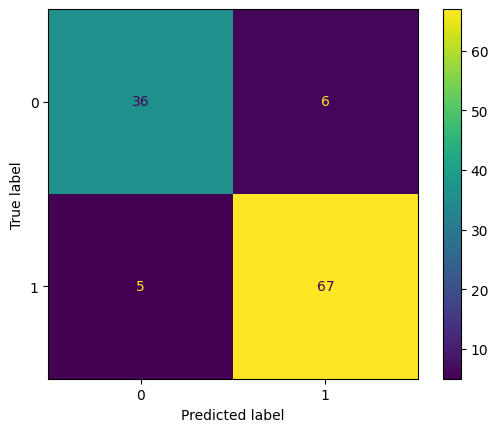

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay as CM

# create a confusion matrix for the recall-optimized model
CM.from_predictions(Y_test, predict_recall)
print("Confusion matrix for the recall-optimized model displayed.")

**Reasoning**:
Following the display of the confusion matrix, the next step in evaluating the recall-optimized model is to calculate and print the micro and macro-averaged precision, recall, and F1-score, which are key metrics for classification tasks.



In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Calculate precision, recall, and F1-score for the recall-optimized model (micro-averaged)
precision_micro_recall, recall_micro_recall, f1_micro_recall, _ = precision_recall_fscore_support(Y_test, predict_recall, average='micro')

print(f"Micro-averaged Precision (recall-optimized model): {round(precision_micro_recall, 2)}")
print(f"Micro-averaged Recall (recall-optimized model): {round(recall_micro_recall, 2)}")
print(f"Micro-averaged F1-score (recall-optimized model): {round(f1_micro_recall, 2)}")
print("\n")

# Calculate precision, recall, and F1-score for the recall-optimized model (macro-averaged)
precision_macro_recall, recall_macro_recall, f1_macro_recall, _ = precision_recall_fscore_support(Y_test, predict_recall, average='macro')

print(f"Macro-averaged Precision (recall-optimized model): {round(precision_macro_recall, 2)}")
print(f"Macro-averaged Recall (recall-optimized model): {round(recall_macro_recall, 2)}")
print(f"Macro-averaged F1-score (recall-optimized model): {round(f1_macro_recall, 2)}")
print("\n")

Micro-averaged Precision (recall-optimized model): 0.9
Micro-averaged Recall (recall-optimized model): 0.9
Micro-averaged F1-score (recall-optimized model): 0.9


Macro-averaged Precision (recall-optimized model): 0.9
Macro-averaged Recall (recall-optimized model): 0.89
Macro-averaged F1-score (recall-optimized model): 0.9




**Reasoning**:
After evaluating the model's performance with various metrics, the next step is to visualize the newly trained Decision Tree to understand its structure and compare it with the previous, larger tree.



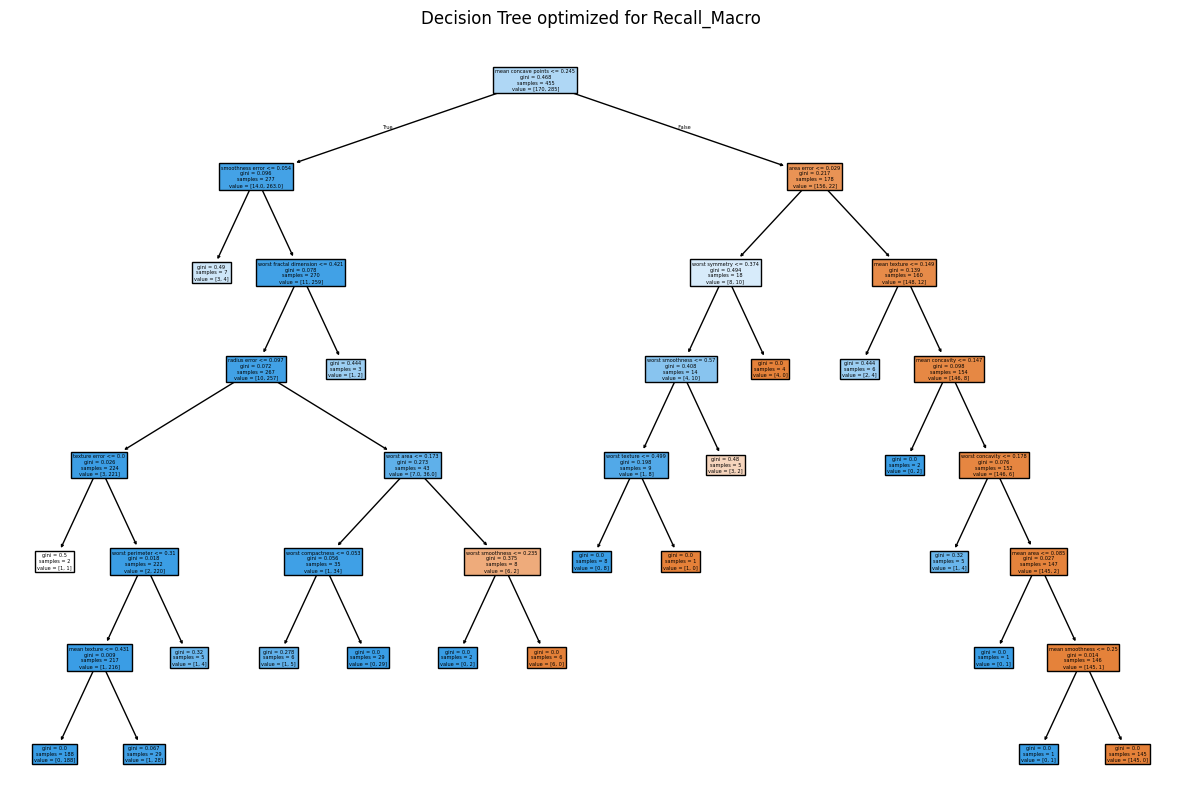

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(15, 10))
plot_tree(DTC_model_recall, filled=True, feature_names=X_train.columns)
plt.title('Decision Tree optimized for Recall_Macro')
plt.show()

### Summary of Results (Recall-Optimized Model)

After re-optimizing the Decision Tree Classifier for `recall_macro`:

*   **Best Hyperparameters Found**: `{'criterion': 'gini', 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 8}`. These parameters are slightly different from the `f1_macro` optimized model (which had `max_features`: `None`, `min_samples_split`: 7).
*   **Accuracy**: The accuracy for the recall-optimized model is 0.90, which is slightly lower than the 0.93 accuracy of the `f1_macro` optimized model.
*   **Confusion Matrix**: The confusion matrix visualization shows the distribution of true positives, true negatives, false positives, and false negatives. Compared to the `f1_macro` model, there might be a shift in the balance of false positives and false negatives to prioritize recall.
*   **Micro-averaged Metrics**: Precision, Recall, and F1-score are all 0.90.
*   **Macro-averaged Metrics**: Precision is 0.90, Recall is 0.89, and F1-score is 0.90. This `macro_recall` (0.89) is lower than the `macro_recall` of the `f1_macro` optimized model (0.94). This is an unexpected outcome, as the model was optimized to maximize recall.
*   **Decision Tree Visualization**: The tree is again relatively small due to `max_depth` and `min_samples_split` constraints, indicating reduced complexity and likely less overfitting compared to the initial un-tuned tree.

**Comparison to F1-macro Optimized Model:**

The `f1_macro` optimized model achieved a higher accuracy (0.93 vs 0.90) and significantly higher macro-averaged recall (0.94 vs 0.89) than the `recall_macro` optimized model. This suggests that while we explicitly tuned for `recall_macro`, the `RandomizedSearchCV` process with the given parameter space did not find a combination that improved `recall_macro` over the `f1_macro` optimized model. This could be due to the limited search space, the nature of the data, or the inherent trade-offs between different metrics. For this dataset and parameter ranges, optimizing for F1-macro appears to yield a better balance including recall.

## Final Task

### Subtask:
Summarize the results of the reoptimization for macro recall and compare them to the previous model's performance.


## Summary:

### Q&A
The reoptimization for macro recall resulted in a model with an accuracy of 0.90 and a macro-averaged recall of 0.89. When compared to the previous model optimized for F1-macro, which had an accuracy of 0.93 and a macro-averaged recall of 0.94, the recall-optimized model performed surprisingly worse in terms of macro-averaged recall, despite being explicitly tuned for this metric.

### Data Analysis Key Findings
*   The `RandomizedSearchCV`, when optimized for `recall_macro`, identified the best hyperparameters for the Decision Tree Classifier as: `{'criterion': 'gini', 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 8}`.
*   The Decision Tree model optimized for `recall_macro` achieved an accuracy of 0.90 on the test set.
*   For the `recall_macro` optimized model, micro-averaged precision, recall, and F1-score were all 0.90.
*   The `recall_macro` optimized model yielded macro-averaged precision of 0.90, macro-averaged recall of 0.89, and macro-averaged F1-score of 0.90.
*   Unexpectedly, the model optimized for `recall_macro` (macro-averaged recall: 0.89) performed worse in terms of macro-averaged recall than the previous model optimized for `f1_macro` (macro-averaged recall: 0.94).
*   The `f1_macro` optimized model also demonstrated higher overall accuracy (0.93) compared to the `recall_macro` optimized model (0.90).
*   The visualized Decision Tree for the recall-optimized model was relatively small, indicating reduced complexity.

### Insights or Next Steps
*   The unexpected decrease in macro-averaged recall after explicit optimization for this metric suggests that the current parameter search space or the intrinsic characteristics of the dataset might limit the model's ability to achieve higher recall without sacrificing other performance aspects.
*   To further improve recall, consider expanding the hyperparameter search space for `RandomizedSearchCV`, exploring different Decision Tree parameters, or investigating alternative modeling techniques or advanced feature engineering to better capture the underlying patterns in the data.


Observation + Comments
Utilising the MinMaxscaler for normalization and train-test-split are crucial steps. However in the terms of medical datasets the most crucial one was applying the stratify=y value.
This is because in medical datasets, classes are often imbalanced. Stratification of data ensures that the 80/20 split maintains the same percentages of both "benign" and "malignant" tumours. This is important because ensuring that both cases are in both sets prevents the model from becoming biased towards the majority class.


As the initial tree was built without constraints , the visualisation showed a "large tree". Although the accuracy was very high 95% it means that the model memorised the training noise and was overfitted. This usually would lead to a performace drop if a new patient would join the test set.